# Fake News Detection : ISOT Dataset

https://www.kaggle.com/datasets/csmalarkodi/isot-fake-news-dataset/data

## Imports

In [1]:
import os
import re
import string
import pickle
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import textstat
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import gensim.downloader as api
from gensim.models import KeyedVectors

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /home/onyxia/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/onyxia/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## 1. Load data

In [3]:
df_fake = pd.read_csv("data/Fake.csv")
df_true = pd.read_csv("data/True.csv")

df_fake["label"] = 0 # label 0 for fake news
df_true["label"] = 1 # label 1 for real news

# Combine the two datasets
df_isot = pd.concat([df_fake, df_true]).sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data
X = df_isot["text"]
y = df_isot["label"]

In [4]:
df_isot.head()

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [5]:
df_isot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


## 2. Data visualization

#### Distribution of Fake/Real news

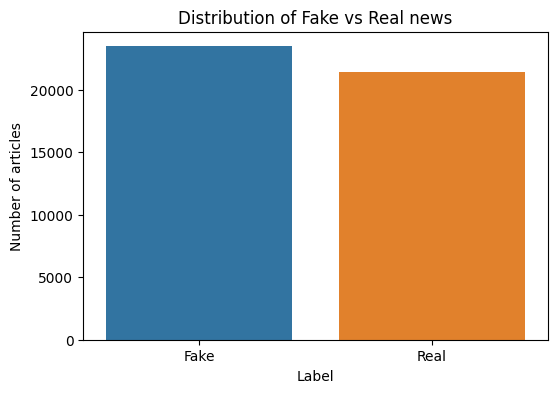

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_isot, x="label", hue="label", legend=False)
plt.title("Distribution of Fake vs Real news")
plt.xlabel("Label")
plt.ylabel("Number of articles")
plt.xticks(ticks=[0, 1], labels=["Fake", "Real"])
plt.show()

In [7]:
df_isot["label"].value_counts()

label
0    23481
1    21417
Name: count, dtype: int64

#### Article subject distribution

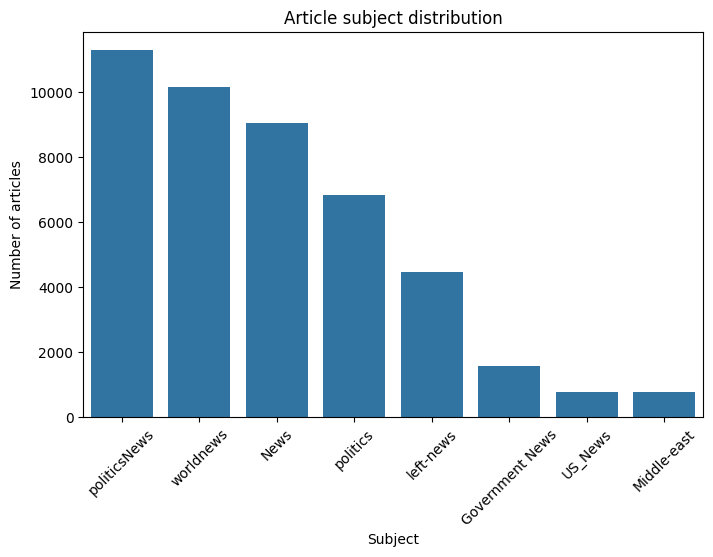

In [40]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_isot, x="subject", order=df_isot["subject"].value_counts().index)
plt.title("Article subject distribution")
plt.xlabel("Subject")
plt.ylabel("Number of articles")
plt.xticks(rotation=45)
plt.show()

#### Article length distribution (in number of words)

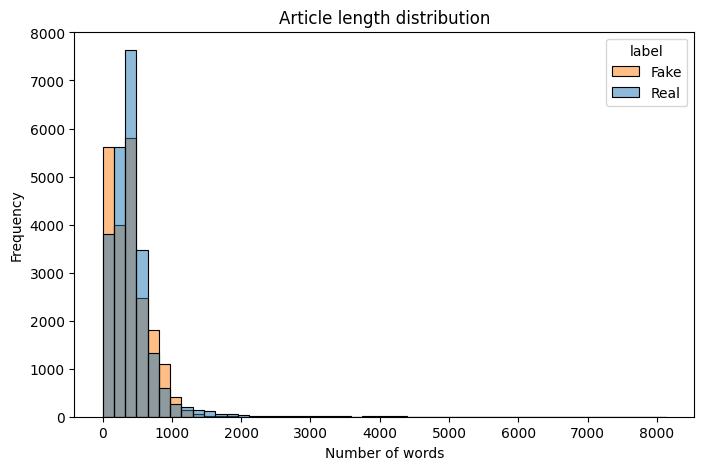

In [9]:
df_isot["article_length"] = df_isot["text"].fillna('').apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(data=df_isot, x="article_length", hue="label", bins=50)
plt.title("Article length distribution")
plt.legend(title="label", labels=["Fake", "Real"])
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

#### Title length distribution (in number of words)

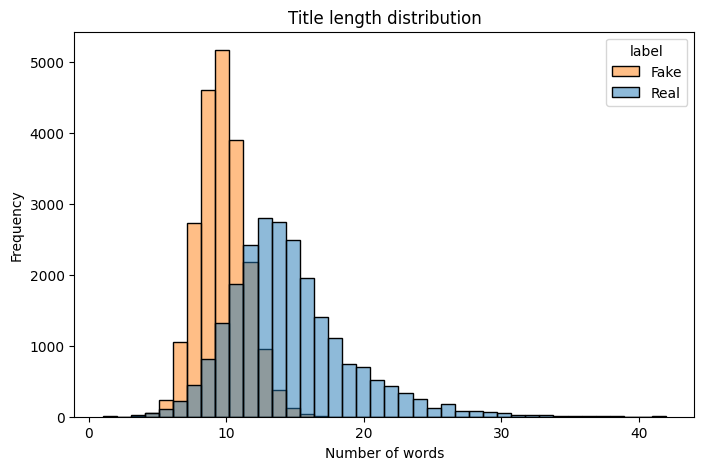

In [10]:
df_isot["title_length"] = df_isot["title"].fillna('').apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(data=df_isot, x="title_length", hue="label", bins=40)
plt.title("Title length distribution")
plt.legend(title="label", labels=["Fake", "Real"])
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

#### Word Cloud of text in Fake vs Real news

In [11]:
def clean_text(text):
    """
    Function to clean text and remove stopwords
    """
    text = re.sub(r"\W+", " ", text.lower())  # remove special caracters and lowercase
    stop_words = stopwords.words("english")
    filtered_tokens = [word for word in text.split() if word not in stop_words and len(word) > 2]
    return ' '.join(filtered_tokens)

In [41]:
df_isot["text_cleaned"] = df_isot["text"].apply(clean_text)

fake_text = " ".join(text for text in df_isot.loc[df_isot["label"] == 0, "text_cleaned"])
real_text = " ".join(text for text in df_isot.loc[df_isot["label"] == 1, "text_cleaned"])

# Word Clouds
fake_text_wc = WordCloud(background_color="white", width=800, height=400, random_state=42).generate(fake_text)
real_text_wc = WordCloud(background_color="white", width=800, height=400, random_state=42).generate(real_text)

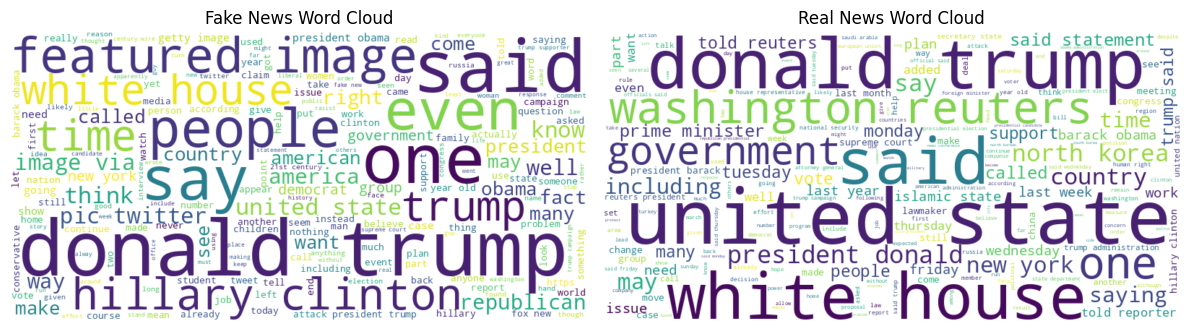

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(fake_text_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Fake News Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(real_text_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Real News Word Cloud")

plt.tight_layout()
plt.show()

## 3. Preprocessing 

In [14]:
def preprocessing_full(text):
    """
    Preprocessing function for models using Bag of Words and TF-IDF (with lemmatization).
    """
    # Lowercase
    text = text.lower()   
    # Remove URLs and Twitter handles
    text = re.sub(r"http\S+|www\S+|https\S+|@\w+", "", text) 
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # Lemmatize and remove stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words("english")
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])    
    return text

In [15]:
def preprocessing_light(text):
    """
    Preprocessing function for models using Word2Vec and BERT (without lemmatization).
    """
    # Lowercase
    text = text.lower()   
    # Remove URLs and Twitter handles
    text = re.sub(r"http\S+|www\S+|https\S+|@\w+", "", text) 
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [16]:
# Apply full preprocessing
X_preprocessed_full = X.apply(preprocessing_full)

In [17]:
# Apply light preprocessing
X_preprocessed_light = X.apply(preprocessing_light)

## 4. Feature extraction

### 4.1. Bag of Words

In [18]:
def get_bow_features(X):
    """
    Extract Bag-of-Words features.
    """
    vectorizer = CountVectorizer(max_features=5000)
    X_bow = vectorizer.fit_transform(X)
    return X_bow, vectorizer

In [19]:
X_bow, bow_vectorizer = get_bow_features(X_preprocessed_full)

### 4.2. TF-IDF

In [20]:
def get_tfidf_features(X):
    """
    Extract TF-IDF features.
    """
    tfidf = TfidfVectorizer(max_features=5000)
    X_tfidf = tfidf.fit_transform(X)
    return X_tfidf, tfidf

In [21]:
X_tfidf, tfidf_vectorizer = get_tfidf_features(X_preprocessed_full)

### 4.3. Word2Vec

In [22]:
def load_word2vec_model(path="word2vec-google-news-300.kv"):
    """
    Load or download the Word2Vec Google News model.
    """
    if os.path.exists(path):
        model = KeyedVectors.load(path)
    else:
        print("Downloading Word2Vec model...")
        model = api.load("word2vec-google-news-300")
        model.save(path)
    print(f"Word2Vec loaded! Vocab size: {len(model.key_to_index)}")
    return model

In [23]:
def get_word2vec_embeddings(texts, model, save_path, vector_size=300):
    """
    Compute or load Word2Vec embeddings from preprocessed texts.
    """    
    if os.path.exists(save_path):
        print("Loading Word2Vec embeddings from cache.")
        with open(save_path, "rb") as f:
            return pickle.load(f)

    print("Computing Word2Vec embeddings...")
    
    def doc_to_vec(doc):
        tokens = doc.split()
        vectors = [model[word] for word in tokens if word in model.key_to_index]
        return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

    embeddings = np.array([doc_to_vec(text) for text in texts])

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, "wb") as f:
        pickle.dump(embeddings, f)
    
    return embeddings

In [24]:
# Load Word2Vec model
word2vec_model = load_word2vec_model()

Word2Vec loaded! Vocab size: 3000000


In [25]:
# Extract or load embeddings
X_word2vec = get_word2vec_embeddings(X_preprocessed_light.tolist(), word2vec_model, "embeddings/isot/word2vec_embeddings.pkl")

Loading Word2Vec embeddings from cache.


In [26]:
X_word2vec.shape

(44898, 300)

### 4.4. BERT

In [27]:
# Load tokenizer and model once
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [28]:
def get_bert_embeddings_batch(texts, save_path, batch_size=32):
    """
    Compute BERT embeddings in batches or load from pickle if available.
    """
    if os.path.exists(save_path):
        print("Loading BERT embeddings from cache.")
        with open(save_path, 'rb') as f:
            return pickle.load(f)
        
    print("Computing BERT embeddings in batches...")
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy()) 
    X_bert = np.vstack(embeddings)

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'wb') as f:
        pickle.dump(X_bert, f)
        
    return X_bert

In [29]:
X_bert = get_bert_embeddings_batch(X_preprocessed_light.tolist(), save_path="embeddings/isot/bert_embeddings.pkl")

Loading BERT embeddings from cache.


In [30]:
X_bert.shape

(44898, 768)

### 4.5. Linguistic Cues

In [31]:
# Dictionnaires de pronoms, conjonctions, etc.
PERSONAL_PRONOUNS = {"i", "we", "she", "he", "him", "her"}
FIRST_PERSON_SINGULAR = {"i", "me"}
FIRST_PERSON_PLURAL = {"we", "us"}
SECOND_PERSON = {"you", "your"}
THIRD_PERSON_SINGULAR = {"she", "he", "her", "him"}
IMPERSONAL_PRONOUNS = {"it", "that", "anything"}
ARTICLES = {"a", "an", "the"}
PREPOSITIONS = {"above", "below", "under", "into", "of", "at", "on", "by", "with", "about", "against", "between", "among", "through", "during", "before", "after", "over", "under", "around", "near"}
AUXILIARY_VERBS = {"be", "am", "is", "are", "was", "were", "being", "been", "have", "has", "had", "having", "do", "does", "did"}
COMMON_ADVERBS = {"just", "usually", "even", "also", "too", "very", "often", "however"}
CONJUNCTIONS = {"and", "but", "or", "yet", "so", "for", "nor", "although", "because", "since", "unless", "until", "while"}
NEGATIONS = {"no", "never", "not"}
COMMON_VERBS = {"run", "walk", "eat", "go", "see", "say", "think"}
COMMON_ADJECTIVES = {"better", "greater", "larger", "smaller", "good", "bad", "happy", "sad"}

PUNCTUATION_MAP = {
    '.': 'full_stop',
    ',': 'comma',
    ':': 'colon',
    ';': 'semicolon',
    '?': 'question_mark',
    '!': 'exclamation_mark',
    '-': 'dash',
    "'": 'apostrophe',
    '(': 'bracket', ')': 'bracket'
}

In [32]:
def extract_linguistic_features(text):
    tokens = word_tokenize(text)
    lower_tokens = [t.lower() for t in tokens]
    num_words = len(tokens)
    num_sents = len(sent_tokenize(text))
    num_syllables = textstat.syllable_count(text)
    long_words = [word for word in tokens if len(word) > 6]
    all_caps = [word for word in tokens if word.isupper() and len(word) > 1]
    unique_words = set(lower_tokens)

    # Punctuation counts
    punct_counts = {name: text.count(symb) for symb, name in PUNCTUATION_MAP.items()}

    def percent(word_set):
        return 100 * sum(1 for word in lower_tokens if word in word_set) / num_words if num_words > 0 else 0

    def percent_pos(pos_prefix):
        pos_tags = pos_tag(tokens)
        return 100 * sum(1 for _, tag in pos_tags if tag.startswith(pos_prefix)) / num_words if num_words > 0 else 0

    features = {
        'word_count': num_words,
        'syllable_count': num_syllables,
        'sentence_count': num_sents,
        'words_per_sentence': num_words / num_sents if num_sents > 0 else 0,
        'long_words_count': len(long_words),
        'all_caps_count': len(all_caps),
        'unique_words_count': len(unique_words),
        'personal_pronouns_percent': percent(PERSONAL_PRONOUNS),
        'first_person_singular_percent': percent(FIRST_PERSON_SINGULAR),
        'first_person_plural_percent': percent(FIRST_PERSON_PLURAL),
        'second_person_percent': percent(SECOND_PERSON),
        'third_person_singular_percent': percent(THIRD_PERSON_SINGULAR),
        'impersonal_pronouns_percent': percent(IMPERSONAL_PRONOUNS),
        'articles_percent': percent(ARTICLES),
        'prepositions_percent': percent(PREPOSITIONS),
        'auxiliary_verbs_percent': percent(AUXILIARY_VERBS),
        'common_adverbs_percent': percent(COMMON_ADVERBS),
        'conjunctions_percent': percent(CONJUNCTIONS),
        'negations_percent': percent(NEGATIONS),
        'common_verbs_percent': percent(COMMON_VERBS),
        'common_adjectives_percent': percent(COMMON_ADJECTIVES),
        'concrete_figures_percent': 100 * len(re.findall(r'\b\d+(?:\.\d+)?\b', text)) / num_words if num_words > 0 else 0,
        'punctuation_count': sum(punct_counts.values())
    }

    # Add individual punctuation counts
    features.update({f"{key}_count": val for key, val in punct_counts.items()})
    
    return features

In [33]:
tqdm.pandas()  # Progress bar
X_linguistic = X.progress_apply(extract_linguistic_features).apply(pd.Series)

  0%|          | 0/44898 [00:00<?, ?it/s]

100%|██████████| 44898/44898 [04:16<00:00, 175.08it/s]


In [34]:
X_linguistic

,word_count,syllable_count,sentence_count,words_per_sentence,long_words_count,all_caps_count,unique_words_count,personal_pronouns_percent,first_person_singular_percent,first_person_plural_percent,...,punctuation_count,full_stop_count,comma_count,colon_count,semicolon_count,question_mark_count,exclamation_mark_count,dash_count,apostrophe_count,bracket_count
0,181.0,281.0,5.0,36.200000,49.0,12.0,121.0,0.000000,0.000000,0.000000,...,10.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,901.0,1309.0,27.0,33.370370,213.0,21.0,376.0,1.331853,0.110988,0.110988,...,99.0,44.0,41.0,0.0,3.0,0.0,0.0,10.0,0.0,1.0
2,349.0,492.0,14.0,24.928571,73.0,4.0,177.0,2.865330,0.000000,1.146132,...,44.0,20.0,17.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0
3,205.0,327.0,9.0,22.777778,53.0,2.0,118.0,3.902439,1.463415,0.487805,...,26.0,12.0,8.0,2.0,0.0,0.0,0.0,3.0,0.0,1.0
4,604.0,848.0,21.0,28.761905,136.0,9.0,309.0,1.821192,0.165563,0.000000,...,62.0,31.0,23.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44894,773.0,1213.0,24.0,32.208333,213.0,10.0,363.0,1.164295,0.258732,0.129366,...,68.0,28.0,20.0,0.0,0.0,0.0,0.0,12.0,0.0,8.0
44895,85.0,116.0,4.0,21.250000,17.0,1.0,64.0,4.705882,1.176471,1.176471,...,11.0,4.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0
44896,1048.0,1234.0,47.0,22.297872,148.0,8.0,424.0,1.717557,0.381679,0.477099,...,141.0,41.0,47.0,3.0,0.0,14.0,4.0,7.0,1.0,24.0


In [35]:
# Save to pickle
with open("embeddings/isot/linguistic_features.pkl", "wb") as f:
    pickle.dump(X_linguistic, f)

## 5. Model training and evaluation

In [36]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [37]:
def train_evaluate_models(features_dict, y, output_dir="models/", cv_folds=5, random_state=42, save_models=True):
    models = {
        "AdaBoost": AdaBoostClassifier(random_state=random_state),
        "GradientBoosting": GradientBoostingClassifier(random_state=random_state),
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=random_state),
        "MLPClassifier": MLPClassifier(max_iter=300, random_state=random_state),
        "RandomForest": RandomForestClassifier(random_state=random_state),
    }

    scoring = {
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score, average="weighted", zero_division=0),
        "recall": make_scorer(recall_score, average="weighted", zero_division=0),
        "f1": make_scorer(f1_score, average="weighted", zero_division=0),
    }

    results = []
    if save_models:
        os.makedirs(output_dir, exist_ok=True)

    for feature_name, X in features_dict.items():
        for model_name, model in models.items():
            print(f"Running cross-validation for {feature_name} and {model_name}")
            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
            scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
            results.append({
                "feature": feature_name,
                "model": model_name,
                "accuracy": np.mean(scores["test_accuracy"]),
                "precision": np.mean(scores["test_precision"]),
                "recall": np.mean(scores["test_recall"]),
                "f1_score": np.mean(scores["test_f1"]),
            })
            # Print scores
            print(f"Accuracy: {np.mean(scores["test_accuracy"]):.4f}")
            print(f"Precision: {np.mean(scores["test_precision"]):.4f}")
            print(f"Recall: {np.mean(scores["test_recall"]):.4f}")
            print(f"F1 Score: {np.mean(scores["test_f1"]):.4f}")
            print('\n')

            if save_models:
                model.fit(X, y)
                filename = os.path.join(output_dir, f"{feature_name}_{model_name}.joblib")
                joblib.dump(model, filename)

    return pd.DataFrame(results)

In [38]:
features_dict = {
    'BoW': X_bow,
    'TF-IDF': X_tfidf,
    'Word2Vec': X_word2vec,
    'BERT': X_bert,
    'Linguistic': X_linguistic,
}

In [39]:
results_df = train_evaluate_models(features_dict, y, output_dir="models/isot")

Running cross-validation for BoW and AdaBoost
Accuracy: 0.9951
Precision: 0.9951
Recall: 0.9951
F1 Score: 0.9951


Running cross-validation for BoW and GradientBoosting
Accuracy: 0.9961
Precision: 0.9961
Recall: 0.9961
F1 Score: 0.9961


Running cross-validation for BoW and LogisticRegression
Accuracy: 0.9964
Precision: 0.9964
Recall: 0.9964
F1 Score: 0.9964


Running cross-validation for BoW and MLPClassifier
Accuracy: 0.9947
Precision: 0.9947
Recall: 0.9947
F1 Score: 0.9947


Running cross-validation for BoW and RandomForest
Accuracy: 0.9985
Precision: 0.9985
Recall: 0.9985
F1 Score: 0.9985


Running cross-validation for TF-IDF and AdaBoost
Accuracy: 0.9948
Precision: 0.9948
Recall: 0.9948
F1 Score: 0.9948


Running cross-validation for TF-IDF and GradientBoosting
Accuracy: 0.9958
Precision: 0.9958
Recall: 0.9958
F1 Score: 0.9958


Running cross-validation for TF-IDF and LogisticRegression
Accuracy: 0.9896
Precision: 0.9897
Recall: 0.9896
F1 Score: 0.9896


Running cross-validation f

/usr/local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptro

Accuracy: 0.9851
Precision: 0.9851
Recall: 0.9851
F1 Score: 0.9851


Running cross-validation for Word2Vec and RandomForest


/usr/local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9580
Precision: 0.9580
Recall: 0.9580
F1 Score: 0.9580


Running cross-validation for BERT and AdaBoost
Accuracy: 0.9539
Precision: 0.9539
Recall: 0.9539
F1 Score: 0.9539


Running cross-validation for BERT and GradientBoosting
Accuracy: 0.9703
Precision: 0.9703
Recall: 0.9703
F1 Score: 0.9703


Running cross-validation for BERT and LogisticRegression
Accuracy: 0.9925
Precision: 0.9925
Recall: 0.9925
F1 Score: 0.9925


Running cross-validation for BERT and MLPClassifier
Accuracy: 0.9951
Precision: 0.9951
Recall: 0.9951
F1 Score: 0.9951


Running cross-validation for BERT and RandomForest
Accuracy: 0.9693
Precision: 0.9694
Recall: 0.9693
F1 Score: 0.9693


Running cross-validation for Linguistic and AdaBoost
Accuracy: 0.9452
Precision: 0.9453
Recall: 0.9452
F1 Score: 0.9452


Running cross-validation for Linguistic and GradientBoosting
Accuracy: 0.9619
Precision: 0.9619
Recall: 0.9619
F1 Score: 0.9619


Running cross-validation for Linguistic and LogisticRegression


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: 0.9211
Precision: 0.9215
Recall: 0.9211
F1 Score: 0.9211




/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Running cross-validation for Linguistic and MLPClassifier
Accuracy: 0.9590
Precision: 0.9605
Recall: 0.9590
F1 Score: 0.9590


Running cross-validation for Linguistic and RandomForest
Accuracy: 0.9723
Precision: 0.9724
Recall: 0.9723
F1 Score: 0.9723


